In [1]:
import json
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

from diskit.components.layer import *
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.compiler import transpile

from diskit_updated.circuit_remapper import *
from ionq.compile_native import compile_to_ionq_native_gates

In [2]:
with open("error_datasheets/Triangulum_SpinQ_3qubits.json", 'r') as f:
    spinq_3q_datasheet = json.load(f)

with open("error_datasheets/Harmony_IonQ_11qubits.json", 'r') as f:
    ionq_11q_datasheet = json.load(f)
with open("error_datasheets/Aria1_IonQ_25qubits.json", 'r') as f:
    ionq_25q_datasheet = json.load(f)
with open("error_datasheets/Forte1_IonQ_36qubits.json", 'r') as f:
    ionq_36q_datasheet = json.load(f)

with open("error_datasheets/IBM_Kyiv_127qubits.json", 'r') as f:
    ibm_kyiv_127q_datasheet = json.load(f)

In [3]:
# GENERAL GATES
measure_gate = 'measure'
reset_gate = 'reset'

# 1. IONQ -> Only valid gates are:
#   - GPI: Puerta IonQ GPi
#   - GPI2: Puerta IonQ GPi2.
#   - MS: Puerta IonQ de Mølmer-Sørenson.

#GPI = Rz(2ϕ)X
#GPI2 = Rz(ϕ)Rx(π/2)Rz(−ϕ)
ionq_predecomposition_gates = ["id", "rx", "ry", "rz", "cx"]
ionq_valid_1qgates = ['gpi', 'gpi2']
ionq_valid_2qgates = ['ms']
ionq_valid_gates = ionq_valid_1qgates + ionq_valid_2qgates

# 2. IBMQ Kyiv -> ECR, ID, RZ, SX, X
ibmq_valid_1qgates = ["id", "rz", "sx", "x"]
ibmq_valid_2qgates = ["ecr"]
ibmq_valid_gates = ibmq_valid_1qgates + ibmq_valid_2qgates

# 3. SpinQ -> H, X, Y, Z, SX, SY, SZ, RX, RY, RZ, T, TDG, S, SDG, CX, CY, CZ
spinq_valid_1qgates = ["id", "h", "x", "sx", "y", "z", "rx", "ry", "rz", "t", "tdg", "s", "sdg"]
spinq_valid_2qgates = ["cx", "cy", "cz"]
spinq_valid_gates = spinq_valid_1qgates + spinq_valid_2qgates

# CIRCUIT TO SIMULATE

In [4]:
def initialize_circuit(qregs = None, n_qubits = None):
    if qregs is None:
        return QuantumCircuit(n_qubits)
    
    qregs_list = qregs.values()
    return QuantumCircuit(*qregs_list)


def get_circuit_max14qubits(qregs = None, n_qubits = None):
    q_circuit = initialize_circuit(qregs, n_qubits)

    q_circuit.h(0)
    for i in range(13):
        q_circuit.cx(i, i+1)

    return q_circuit


def get_circuit_max30qubits(qregs = None, n_qubits = None):
    q_circuit = initialize_circuit(qregs, n_qubits)

    q_circuit.h(0)
    for i in range(29):
        q_circuit.cx(i, i+1)

    return q_circuit


def get_circuit_max120qubits(qregs = None, n_qubits = None):
    q_circuit = initialize_circuit(qregs, n_qubits)

    q_circuit.h(0)
    for i in range(119):
        q_circuit.cx(i, i+1)
    
    return q_circuit

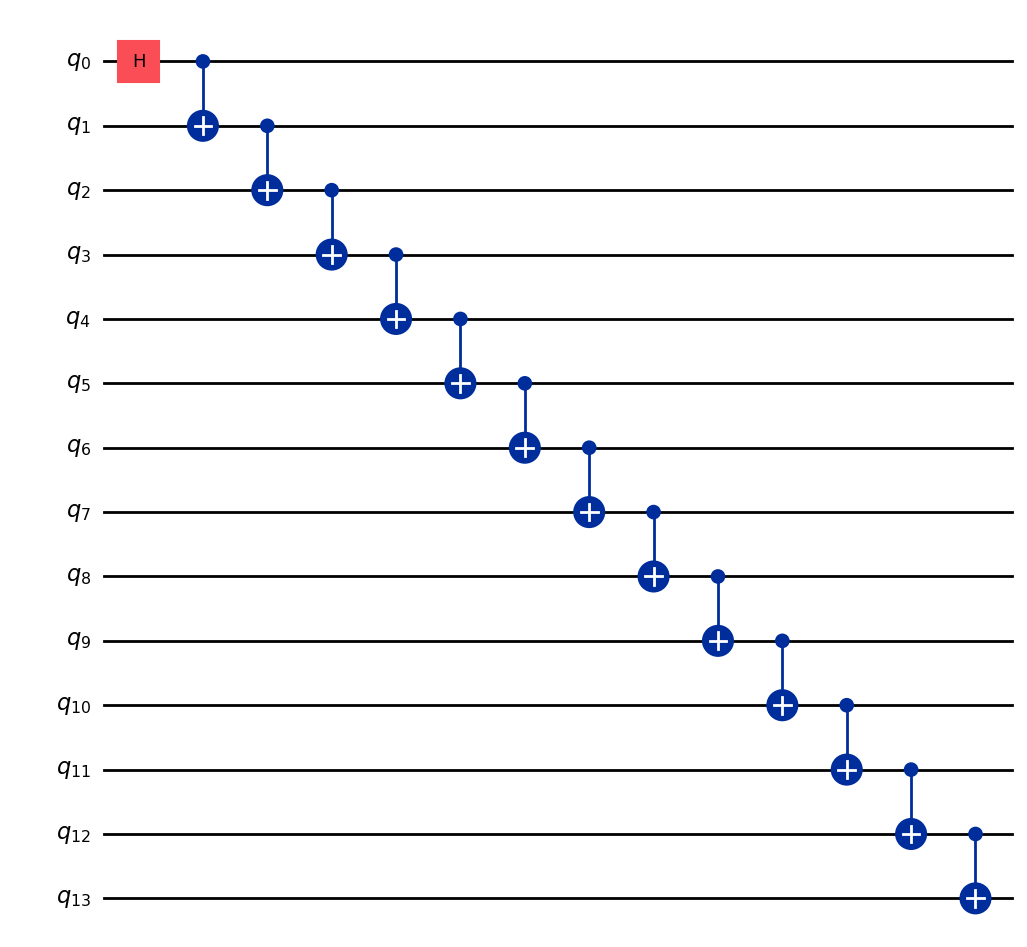

In [5]:
get_circuit_max14qubits(n_qubits=14).draw(output="mpl")

# DISTRIBUTED UTILITIES

In [6]:
def create_distributed_topology(n_nodes, qubits_per_qnode):
    circuit_topo = Topology()
    circuit_topo.create_qmap(n_nodes, [qubits_per_qnode for _ in range(n_nodes)], "qnode")

    qregs = {}

    for qpu in circuit_topo.qmap:
        reg = circuit_topo.qmap[qpu][0]._register
        qregs[reg.name] = reg
    for qpu in circuit_topo.emap:
        reg = circuit_topo.emap[qpu]._register
        qregs[reg.name] = reg
    
    return circuit_topo, qregs

In [7]:
def remap_circuit(qc, circuit_topo, qregs, decompose_list=None, measure=False):
    remapper = CircuitRemapper(circuit_topo)
    if decompose_list is None:
        dist_circ = remapper.remap_circuit(qc)
    else:
        dist_circ = remapper.remap_circuit(qc, decompose=True, decompose_list=decompose_list)

    if measure:
        measure_reg_q0 = ClassicalRegister(len(qregs['qnode0']), name="measure_qnode0")
        measure_reg_q1 = ClassicalRegister(len(qregs['qnode1']), name="measure_qnode1")
        dist_circ.add_register(measure_reg_q0)
        dist_circ.add_register(measure_reg_q1)
        #dist_circ.barrier()
        dist_circ.measure(qregs['qnode0'], measure_reg_q0)
        dist_circ.measure(qregs['qnode1'], measure_reg_q1)

    return dist_circ

# ANALISIS CIRCUITOS

- Calculo de la fidelidad total

In [8]:
import math

def calculate_total_fidelity(
    count_operations: OrderedDict, 
    op_list_1q: list[str], 
    op_list_2q: list[str],
    config_json: dict[str, object]
) -> float:
    
    #total_error = 0
    total_fidelity = 1.0
    fidelity_config = config_json["fidelity"]

    for op_1q in op_list_1q:
        if op_1q in count_operations:
            #total_error += count_operations[op_1q] * (1 - fidelity_config['1Q']['mean'])
            total_fidelity *= math.pow(fidelity_config['1Q']['mean'], count_operations[op_1q])

    for op_2q in op_list_2q:
        if op_2q in count_operations:
            #total_error += count_operations[op_2q] * (1 - fidelity_config['2Q']['mean'])
            total_fidelity *= math.pow(fidelity_config['2Q']['mean'], count_operations[op_2q])

    if measure_gate in count_operations:
        #total_error += count_operations[measure_gate] * (1 - fidelity_config['readout']['mean'])
        total_fidelity *= math.pow(fidelity_config['readout']['mean'], count_operations[measure_gate])

    #return 1 - total_error
    return total_fidelity

- Benchmark de diferentes máquinas y algoritmos:

In [9]:
from itertools import permutations

def compute_metrics(
    count_operations: OrderedDict,
    machine_type_config: dict[str, object],

):
    if machine_type_config["machine"] == "ionq":
        fidelity = calculate_total_fidelity(count_operations, ionq_valid_1qgates, 
                                            ionq_valid_2qgates, machine_type_config)
    elif machine_type_config["machine"] == "ibmq":
        fidelity = calculate_total_fidelity(count_operations, ibmq_valid_1qgates, 
                                            ibmq_valid_2qgates, machine_type_config)
    elif machine_type_config["machine"] == "spinq":
        fidelity = calculate_total_fidelity(count_operations, ibmq_valid_1qgates, 
                                            ibmq_valid_2qgates, machine_type_config)
    
    return fidelity


def benchmark_distributed_execution(
    benchmark_machine_list: list[tuple[dict[str, object], int, int]],
    circuit_function,
    saved_counts: list[OrderedDict] = None
):
    dist_circuits = []
    output_circuits = []

    qubits_list = []
    fidelity_list = []
    duration_list = []

    for idx, (machine_type_config, n_qnodes, qubits_per_qnode) in enumerate(benchmark_machine_list):
        if saved_counts is not None and idx < len(saved_counts):
            fidelity = compute_metrics(saved_counts[idx], machine_type_config)
        else:
            print(f"* Starting analysis with {machine_type_config['machine']} - {n_qnodes} qnodes - {qubits_per_qnode} qubits per qnode:")
            if machine_type_config["machine"] == "ionq":
                decompose_list = ionq_predecomposition_gates
            else:
                decompose_list = ibmq_valid_gates

            if n_qnodes == 1:
                dist_circuit = circuit_function(n_qubits=qubits_per_qnode)
            else:
                circuit_topo, qregs = create_distributed_topology(n_nodes=n_qnodes, qubits_per_qnode=qubits_per_qnode)
                initial_circuit = circuit_function(qregs=qregs)

                # Es necesario antes de remapear el circuito transpilarlo a puertas basicas
                # (para descomponer puertas de más de 2 qubits)
                print("\t- Initializing distributed mapping...")
                initial_circuit = transpile(initial_circuit, basis_gates=decompose_list)
                # Remapeamos el circuito a formato distribuido
                print("\t- Remapping circuit...")
                dist_circuit = remap_circuit(qc=initial_circuit, circuit_topo=circuit_topo, qregs=qregs)
            
            print("\t-Executing final compilation...")
            if machine_type_config["machine"] == "ionq":
                output_ionq_circuit = compile_to_ionq_native_gates(dist_circuit, check=False)

                ionq_instruction_durations = (
                    [(gate, qubit, machine_type_config["timing (us)"]['1Q']/1000000, 's') for qubit in range(len(dist_circuit.qubits)) for gate in ionq_valid_1qgates] +
                    [(gate, qubits, machine_type_config["timing (us)"]['2Q']/1000000, 's') for qubits in permutations(range(len(dist_circuit.qubits)), 2) for gate in ionq_valid_2qgates] +
                    [('measure', qubit, machine_type_config["timing (us)"]['readout']/1000000, 's') for qubit in range(len(dist_circuit.qubits))] +
                    [('reset', qubit, machine_type_config["timing (us)"]['reset']/1000000, 's') for qubit in range(len(dist_circuit.qubits))]
                )
                output_circuit = transpile(output_ionq_circuit, basis_gates=ionq_valid_gates,
                                           coupling_map=[list(qubits) for qubits in permutations(range(len(dist_circuit.qubits)), 2)],
                                           initial_layout=[qubit for qubit in range(len(dist_circuit.qubits))],
                                           scheduling_method="asap", instruction_durations=ionq_instruction_durations)
            elif machine_type_config["machine"] == "ibmq":
                ibmq_instruction_durations = (
                    [(gate, qubit, machine_type_config["timing (us)"]['1Q']/1000000, 's') for qubit in range(len(dist_circuit.qubits)) for gate in ibmq_valid_1qgates] +
                    [(gate, qubits, machine_type_config["timing (us)"]['2Q']/1000000, 's') for qubits in permutations(range(len(dist_circuit.qubits)), 2) for gate in ibmq_valid_2qgates] +
                    [('measure', qubit, machine_type_config["timing (us)"]['readout']/1000000, 's') for qubit in range(len(dist_circuit.qubits))] +
                    [('reset', qubit, machine_type_config["timing (us)"]['reset']/1000000, 's') for qubit in range(len(dist_circuit.qubits))]
                )
                output_circuit = transpile(dist_circuit, basis_gates=ibmq_valid_gates,
                                           coupling_map=[list(qubits) for qubits in permutations(range(len(dist_circuit.qubits)), 2)],
                                           initial_layout=[qubit for qubit in range(len(dist_circuit.qubits))],
                                           scheduling_method="asap", instruction_durations=ibmq_instruction_durations)
                
            elif machine_type_config["machine"] == "spinq":
                spinq_instruction_durations = (
                    [(gate, qubit, machine_type_config["timing (us)"]['1Q']/1000000, 's') for qubit in range(len(dist_circuit.qubits)) for gate in spinq_valid_1qgates] +
                    [(gate, qubits, machine_type_config["timing (us)"]['2Q']/1000000, 's') for qubits in permutations(range(len(dist_circuit.qubits)), 2) for gate in spinq_valid_2qgates] +
                    [('measure', qubit, machine_type_config["timing (us)"]['readout']/1000000, 's') for qubit in range(len(dist_circuit.qubits))] +
                    [('reset', qubit, machine_type_config["timing (us)"]['reset']/1000000, 's') for qubit in range(len(dist_circuit.qubits))]
                )
                output_circuit = transpile(dist_circuit, basis_gates=spinq_valid_gates,
                                           coupling_map=[list(qubits) for qubits in permutations(range(len(dist_circuit.qubits)), 2)],
                                           initial_layout=[qubit for qubit in range(len(dist_circuit.qubits))],
                                           scheduling_method="asap", instruction_durations=spinq_instruction_durations)

            print(f"Duration: {output_circuit.duration}")
            
            duration_list.append(output_circuit.duration)
            dist_circuits.append(dist_circuit)
            output_circuits.append(output_circuit)
            count_operations = output_circuit.count_ops()
        
            fidelity = compute_metrics(count_operations, machine_type_config)
        
        fidelity_list.append(fidelity)
        qubits_list.append(qubits_per_qnode)
            
    return dist_circuits, output_circuits, duration_list, qubits_list, fidelity_list

# EXECUTION SPINQ AND IONQ MACHINES WITH 14 QUBIT ALGORITHM

In [10]:
dist_circuits, output_circuits, duration_list, qubits_list, fidelity_list = benchmark_distributed_execution(
    benchmark_machine_list=[
        (spinq_3q_datasheet, 7, 2), 
        (ionq_11q_datasheet, 2, 10), 
        (ionq_25q_datasheet, 1, 24)
    ],
    circuit_function=get_circuit_max14qubits,
)

* Starting analysis with spinq - 7 qnodes - 2 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.0039896
* Starting analysis with ionq - 2 qnodes - 10 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.0023700000000000006
* Starting analysis with ionq - 1 qnodes - 24 qubits per qnode:
	-Executing final compilation...
Duration: 0.011714999999999995


(0.25, 0.87)

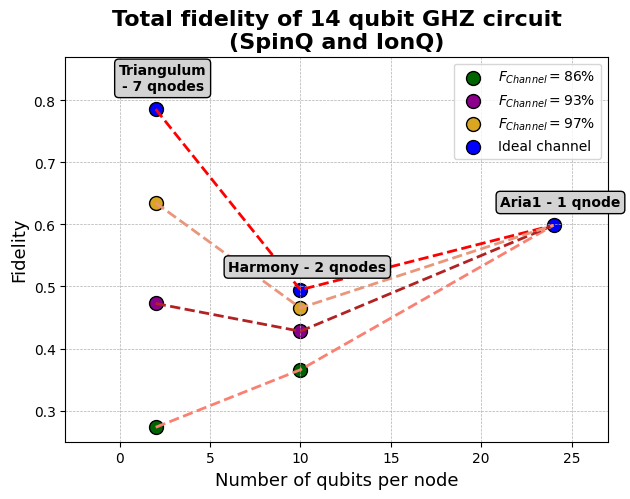

In [11]:
labels = ["Triangulum\n- 7 qnodes", "Harmony - 2 qnodes", "Aria1 - 1 qnode"]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

f_86 = [fidelity_list[0]*(0.86**7), fidelity_list[1]*(0.86**2), fidelity_list[2]]
f_93 = [fidelity_list[0]*(0.93**7), fidelity_list[1]*(0.93**2), fidelity_list[2]]
f_97 = [fidelity_list[0]*(0.97**7), fidelity_list[1]*(0.97**2), fidelity_list[2]]

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, fidelity_list, 2)
trendline = np.poly1d(coefficients)

coefficients_86 = np.polyfit(qubits_list, f_86, 2)
trendline_86 = np.poly1d(coefficients_86)

coefficients_93 = np.polyfit(qubits_list, f_93, 2)
trendline_93 = np.poly1d(coefficients_93)

coefficients_97 = np.polyfit(qubits_list, f_97, 2)
trendline_97 = np.poly1d(coefficients_97)

# Configuración del gráfico
ax.scatter(qubits_list[:-1], f_86[:-1], color='darkgreen', s=100, edgecolors='k', label=r'$F_{Channel} = 86\%$')
ax.scatter(qubits_list[:-1], f_93[:-1], color='darkmagenta', s=100, edgecolors='k', label=r'$F_{Channel} = 93\%$')
ax.scatter(qubits_list[:-1], f_97[:-1], color='goldenrod', s=100, edgecolors='k', label=r'$F_{Channel} = 97\%$')
ax.scatter(qubits_list, fidelity_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_86(qubits_list), color='salmon', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_93(qubits_list), color='firebrick', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_97(qubits_list), color='darksalmon', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], fidelity_list[i] + 0.019), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total fidelity of 14 qubit GHZ circuit\n(SpinQ and IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Fidelity', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(fidelity_list), max(fidelity_list)
plt.xlim(xmin-5, xmax+3)
plt.ylim(0.25, 0.87)
#plt.ylim(ymin-0.010, ymax + 0.045)

(0.0019027500000000008, 0.013116749999999993)

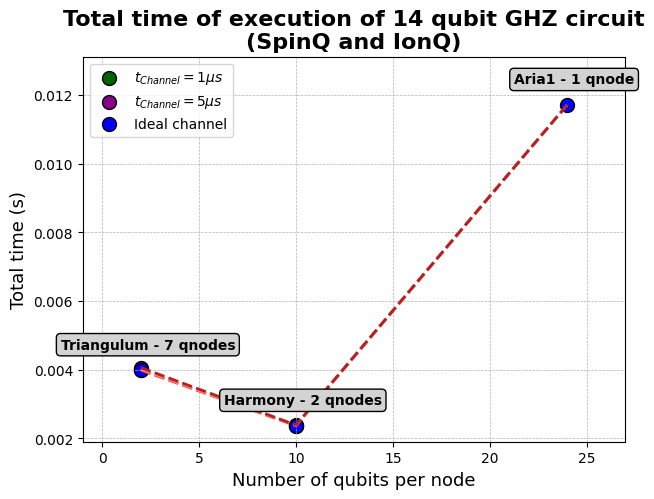

In [12]:
labels = ["Triangulum - 7 qnodes", "Harmony - 2 qnodes", "Aria1 - 1 qnode"]
# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(duration_list), max(duration_list)
range_values_y = ymax - ymin

f_min = [duration_list[0]+(1e-6*7*2), duration_list[1]+(1e-6*2*2), duration_list[2]]
f_max = [duration_list[0]+(5e-6*7*2), duration_list[1]+(5e-6*2*2), duration_list[2]]

coefficients_min = np.polyfit(qubits_list, f_min, 2)
trendline_min = np.poly1d(coefficients_min)

coefficients_max = np.polyfit(qubits_list, f_max, 2)
trendline_max = np.poly1d(coefficients_max)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, duration_list, 2)
trendline = np.poly1d(coefficients)

# Configuración del gráfico
ax.scatter(qubits_list[:-1], f_min[:-1], color='darkgreen', s=100, edgecolors='k', label=r'$t_{Channel} = 1µs$')
ax.scatter(qubits_list[:-1], f_max[:-1], color='darkmagenta', s=100, edgecolors='k', label=r'$t_{Channel} = 5µs$')
ax.scatter(qubits_list, duration_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_min(qubits_list), color='salmon', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_max(qubits_list), color='firebrick', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], duration_list[i] + range_values_y * 0.045), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total time of execution of 14 qubit GHZ circuit\n(SpinQ and IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Total time (s)', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.xlim(xmin-3, xmax+3)
plt.ylim(ymin - range_values_y * 0.05, ymax + range_values_y * 0.15)

# EXECUTION IONQ MACHINES WITH 30 QUBIT ALGORITHM

In [13]:
dist_circuits, output_circuits, duration_list, qubits_list, fidelity_list = benchmark_distributed_execution(
    benchmark_machine_list=[
        (spinq_3q_datasheet, 15, 2),
        (ionq_11q_datasheet, 3, 10), 
        (ionq_25q_datasheet, 2, 24), 
        (ionq_36q_datasheet, 1, 36)
    ],
    circuit_function=get_circuit_max30qubits,
)

* Starting analysis with spinq - 15 qnodes - 2 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.0091224
* Starting analysis with ionq - 3 qnodes - 10 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.0031100000000000017
* Starting analysis with ionq - 2 qnodes - 24 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.02146999999999999
* Starting analysis with ionq - 1 qnodes - 36 qubits per qnode:
	-Executing final compilation...
Duration: 0.03606000000000001


(0.017869379768347682, 0.8449549400396024)

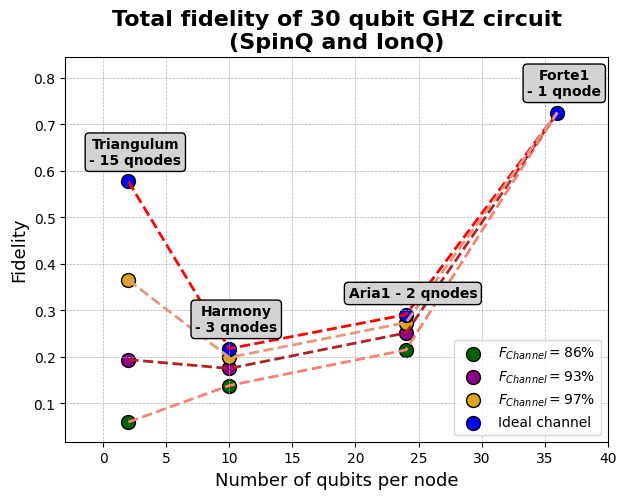

In [14]:
labels = ["Triangulum\n- 15 qnodes", "Harmony\n- 3 qnodes", "Aria1 - 2 qnodes", "Forte1\n- 1 qnode"]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

f_86 = [fidelity_list[0]*(0.86**15), fidelity_list[1]*(0.86**3), fidelity_list[2]*(0.86**2), fidelity_list[3]]
f_93 = [fidelity_list[0]*(0.93**15), fidelity_list[1]*(0.93**3), fidelity_list[2]*(0.93**2), fidelity_list[3]]
f_97 = [fidelity_list[0]*(0.97**15), fidelity_list[1]*(0.97**3), fidelity_list[2]*(0.97**2), fidelity_list[3]]

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, fidelity_list, 3)
trendline = np.poly1d(coefficients)

coefficients_86 = np.polyfit(qubits_list, f_86, 3)
trendline_86 = np.poly1d(coefficients_86)

coefficients_93 = np.polyfit(qubits_list, f_93, 3)
trendline_93 = np.poly1d(coefficients_93)

coefficients_97 = np.polyfit(qubits_list, f_97, 3)
trendline_97 = np.poly1d(coefficients_97)

# Configuración del gráfico
ax.scatter(qubits_list[:-1], f_86[:-1], color='darkgreen', s=100, edgecolors='k', label=r'$F_{Channel} = 86\%$')
ax.scatter(qubits_list[:-1], f_93[:-1], color='darkmagenta', s=100, edgecolors='k', label=r'$F_{Channel} = 93\%$')
ax.scatter(qubits_list[:-1], f_97[:-1], color='goldenrod', s=100, edgecolors='k', label=r'$F_{Channel} = 97\%$')
ax.scatter(qubits_list, fidelity_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_86(qubits_list), color='salmon', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_93(qubits_list), color='firebrick', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_97(qubits_list), color='darksalmon', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], fidelity_list[i] + 0.022), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total fidelity of 30 qubit GHZ circuit\n(SpinQ and IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Fidelity', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(fidelity_list), max(fidelity_list)
plt.xlim(xmin-5, xmax+4)
plt.ylim(ymin-0.20, ymax + 0.12)

(0.0014625000000000011, 0.04100250000000001)

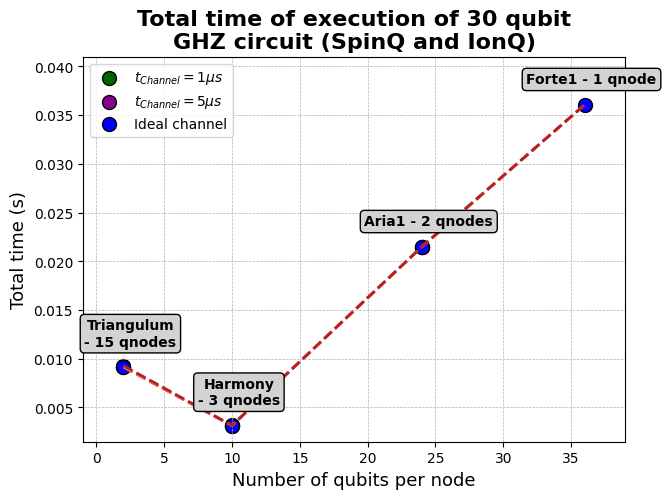

In [15]:
labels = ["Triangulum\n- 15 qnodes", "Harmony\n- 3 qnodes", "Aria1 - 2 qnodes", "Forte1 - 1 qnode"]
# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(duration_list), max(duration_list)
range_values_y = ymax - ymin

f_min = [duration_list[0]+(1e-6*15*2), duration_list[1]+(1e-6*3*2), duration_list[2]+(1e-6*2*2), duration_list[3]]
f_max = [duration_list[0]+(5e-6*15*2), duration_list[1]+(5e-6*3*2), duration_list[2] +(5e-6*2*2), duration_list[3]]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, duration_list, 3)
trendline = np.poly1d(coefficients)

coefficients_min = np.polyfit(qubits_list, f_min, 3)
trendline_min = np.poly1d(coefficients_min)

coefficients_max = np.polyfit(qubits_list, f_max, 3)
trendline_max = np.poly1d(coefficients_max)


# Configuración del gráfico
ax.scatter(qubits_list[:-1], f_min[:-1], color='darkgreen', s=100, edgecolors='k', label=r'$t_{Channel} = 1µs$')
ax.scatter(qubits_list[:-1], f_max[:-1], color='darkmagenta', s=100, edgecolors='k', label=r'$t_{Channel} = 5µs$')
ax.scatter(qubits_list, duration_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_min(qubits_list), color='salmon', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_max(qubits_list), color='firebrick', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], duration_list[i] + range_values_y * 0.045), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total time of execution of 30 qubit\nGHZ circuit (SpinQ and IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Total time (s)', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.xlim(xmin-3, xmax+3)
plt.ylim(ymin - range_values_y * 0.05, ymax + range_values_y * 0.15)

#### EXAMPLE OF IONQ COMPILATION

In [16]:
#output_circuits[0].draw(output='mpl')

# COMPARISON IONQ V.S IBMQ MACHINES WITH 120 QUBIT ALGORITHM

In [17]:
dist_circuits, output_circuits, duration_list, qubits_list, fidelity_list = benchmark_distributed_execution(
    benchmark_machine_list=[
        (spinq_3q_datasheet, 60, 2),
        (ionq_11q_datasheet, 12, 10), 
        (ionq_25q_datasheet, 5, 24), 
        (ionq_36q_datasheet, 4, 35),
        (ibm_kyiv_127q_datasheet, 1, 127)
    ],
    circuit_function=get_circuit_max120qubits
)

* Starting analysis with spinq - 60 qnodes - 2 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.03799439999999987
* Starting analysis with ionq - 12 qnodes - 10 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.008959999999999973
* Starting analysis with ionq - 5 qnodes - 24 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.030899999999999976
* Starting analysis with ionq - 4 qnodes - 35 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
	-Executing final compilation...
Duration: 0.04953999999999995
* Starting analysis with ibmq - 1 qnodes - 127 qubits per qnode:
	-Executing final compilation...
Duration: 0.00013538849800000054


(-0.0025984826446832756, 0.26374325621681594)

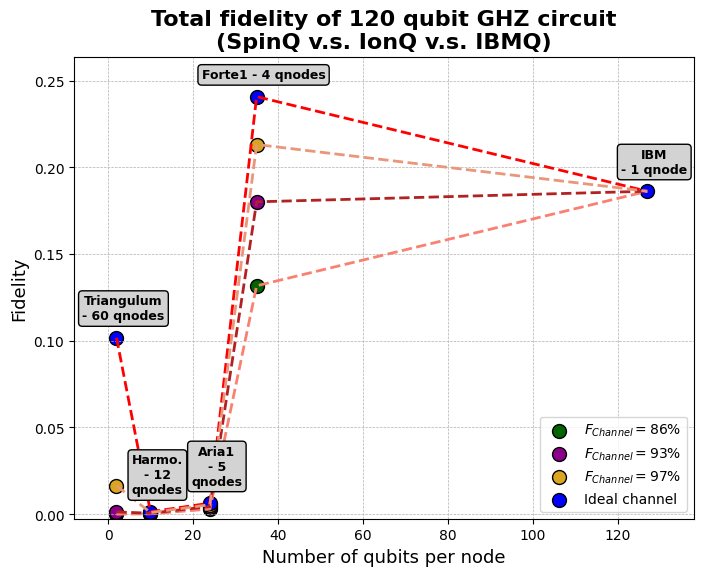

In [18]:
labels = ["Triangulum\n- 60 qnodes", "Harmo.\n- 12\nqnodes", "Aria1\n- 5\nqnodes", "Forte1 - 4 qnodes", "IBM\n- 1 qnode"]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

f_86 = [fidelity_list[0]*(0.86**60), fidelity_list[1]*(0.86**12), fidelity_list[2]*(0.86**5), fidelity_list[3]*(0.86**4), fidelity_list[4]]
f_93 = [fidelity_list[0]*(0.93**60), fidelity_list[1]*(0.93**12), fidelity_list[2]*(0.93**5), fidelity_list[3]*(0.93**4), fidelity_list[4]]
f_97 = [fidelity_list[0]*(0.97**60), fidelity_list[1]*(0.97**12), fidelity_list[2]*(0.97**5), fidelity_list[3]*(0.97**4), fidelity_list[4]]

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, fidelity_list, 4)
trendline = np.poly1d(coefficients)

coefficients_86 = np.polyfit(qubits_list, f_86, 4)
trendline_86 = np.poly1d(coefficients_86)

coefficients_93 = np.polyfit(qubits_list, f_93, 4)
trendline_93 = np.poly1d(coefficients_93)

coefficients_97 = np.polyfit(qubits_list, f_97, 4)
trendline_97 = np.poly1d(coefficients_97)

# Configuración del gráfico
ax.scatter(qubits_list[:-1], f_86[:-1], color='darkgreen', s=100, edgecolors='k', label=r'$F_{Channel} = 86\%$')
ax.scatter(qubits_list[:-1], f_93[:-1], color='darkmagenta', s=100, edgecolors='k', label=r'$F_{Channel} = 93\%$')
ax.scatter(qubits_list[:-1], f_97[:-1], color='goldenrod', s=100, edgecolors='k', label=r'$F_{Channel} = 97\%$')
ax.scatter(qubits_list, fidelity_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_86(qubits_list), color='salmon', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_93(qubits_list), color='firebrick', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_97(qubits_list), color='darksalmon', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], fidelity_list[i] + 0.0065), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=9, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total fidelity of 120 qubit GHZ circuit\n(SpinQ v.s. IonQ v.s. IBMQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Fidelity', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(fidelity_list), max(fidelity_list)
plt.xlim(xmin-10, xmax+11)
plt.ylim(ymin-0.004, ymax + 0.023)

(-0.002334842077099997, 0.05695069172529994)

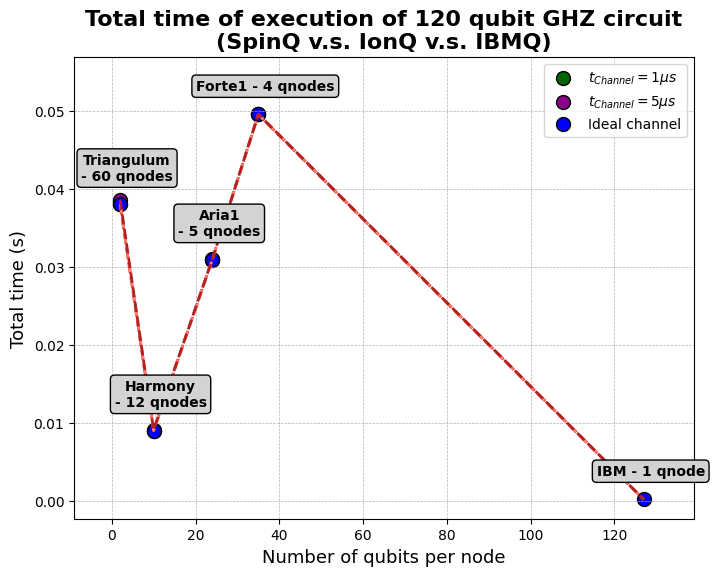

In [19]:
labels = ["Triangulum\n- 60 qnodes", "Harmony\n- 12 qnodes", "Aria1\n- 5 qnodes", "Forte1 - 4 qnodes", "IBM - 1 qnode"]
# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(duration_list), max(duration_list)
range_values_y = ymax - ymin

f_min = [duration_list[0]+(1e-6*60*2), duration_list[1]+(1e-6*12*2), duration_list[2]+(1e-6*5*2), duration_list[3]+(1e-6*4*2), duration_list[4]]
f_max = [duration_list[0]+(5e-6*60*2), duration_list[1]+(5e-6*12*2), duration_list[2]+(5e-6*5*2), duration_list[3]+(5e-6*4*2), duration_list[4]]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, duration_list, 4)
trendline = np.poly1d(coefficients)

coefficients_min = np.polyfit(qubits_list, f_min, 4)
trendline_min = np.poly1d(coefficients_min)

coefficients_max = np.polyfit(qubits_list, f_max, 4)
trendline_max = np.poly1d(coefficients_max)


# Configuración del gráfico
ax.scatter(qubits_list[:-1], f_min[:-1], color='darkgreen', s=100, edgecolors='k', label=r'$t_{Channel} = 1µs$')
ax.scatter(qubits_list[:-1], f_max[:-1], color='darkmagenta', s=100, edgecolors='k', label=r'$t_{Channel} = 5µs$')
ax.scatter(qubits_list, duration_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_min(qubits_list), color='salmon', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_max(qubits_list), color='firebrick', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], duration_list[i] + range_values_y * 0.045), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total time of execution of 120 qubit GHZ circuit\n(SpinQ v.s. IonQ v.s. IBMQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Total time (s)', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.xlim(xmin-11, xmax+12)
plt.ylim(ymin - range_values_y * 0.05, ymax + range_values_y * 0.15)